# Сборный проект

### Описание проекта
Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».


In [ ]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from scipy.stats import binom, poisson, norm
from math import sqrt, factorial

In [ ]:
# Настройки
# Отображение всех колонок таблиц
pd.set_option('display.max_columns', None)

In [ ]:
# Функция для отрисовывания столбчатых диаграмм
def graph_bar(data, yaxes, xlab, ylab, title):
    plt.figure(figsize=(10,6))
    ax = sns.barplot(x = data.index, y = yaxes, data = data)
    ax.set(xlabel = xlab, ylabel = ylab, title = title)
    plt.xticks(rotation = 45)
    plt.show()

In [ ]:
# Функция для отрисовывания столбчатых диаграмм
def graph_line(data, xaxes, yaxes, xlab, ylab, title):
    plt.figure(figsize=(10,6))
    ax = sns.lineplot(x = xaxes, y = yaxes, data = data, hue = 'platform')
    ax.set(xlabel = xlab, ylabel = ylab, title = title)
    plt.show()

In [ ]:
# Функция для отрисовывания столбчатых диаграмм
def graph_box(xaxes, yaxes, xlab, ylab, xlim, title):
    plt.figure(figsize=(10,6))
    ax = sns.boxplot(x = xaxes, y = yaxes)
    ax.set(xlabel = xlab, ylabel = ylab, xlim = xlim, title = title)
    plt.show()

In [ ]:
# Функция для отрисовывания графиков корреляции
def graph_scatter(data, platform):
    plt.figure(figsize=(10,6))
    ax = sns.scatterplot(x='total_sales', y='critic_score', data = data, alpha = 0.5, color='red',)
    ax = sns.scatterplot(x='total_sales', y='user_score', data = data, alpha = 0.2, color='blue');
    ax.set(xlabel = 'Продажи (млн. копий)', ylabel = 'Оценки', title = platform)
    plt.show()
    print(f'Корреляция продаж и оценки критиков для платформы "{platform}":',
        round(data['total_sales'].corr(data['critic_score']),3))
    print(f'Корреляция продаж и оценки пользователей для платформы "{platform}":',
        round(data['total_sales'].corr(data['user_score']),3))

In [ ]:
# Функция для отрисовывания круговых диаграмм
def graph_pie(data, title):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8,8))
    palette = sns.color_palette('pastel')[ 0:5 ]
    fig.suptitle(title)
    ax1.pie(data['na_sales'], labels = data.index, autopct='%1.1f%%', colors = palette, normalize=True)
    ax1.set_title('Суверная Америка')
    ax2.pie(data['eu_sales'], labels = data.index, autopct='%1.1f%%', colors = palette, normalize=True)
    ax2.set_title('Европа')
    ax3.pie(data['jp_sales'], labels = data.index, autopct='%1.1f%%', colors = palette, normalize=True)
    ax3.set_title('Япония')
    ax4.pie(data['other_sales'], labels = data.index, autopct='%1.1f%%', colors = palette, normalize=True)
    ax4.set_title('Другие регионы')
    fig.tight_layout()

# 1. Загрузка данных

In [ ]:
try:
    df = pd.read_csv('/datasets/games.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')

In [ ]:
# вывода информации о датасете
print(df.info())
display(df.sample(15))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
None


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
14395,Travel Coach: Europe 1,DS,2008.0,Misc,0.00,0.03,0.00,0.00,NaN,NaN,NaN
5076,Tiger Woods PGA Tour 09,PS2,2008.0,Sports,0.16,0.00,0.00,0.21,NaN,4.3,E
16695,Planet Monsters,GBA,2001.0,Action,0.01,0.00,0.00,0.00,67.0,tbd,E
989,LEGO Star Wars III: The Clone Wars,Wii,2011.0,Action,1.01,0.60,0.00,0.15,76.0,7.7,E10+
6202,Yu-Gi-Oh! World Championship 2008,DS,2007.0,Strategy,0.13,0.02,0.12,0.01,NaN,NaN,NaN
14667,Drome Racers,GC,2003.0,Racing,0.02,0.01,0.00,0.00,54.0,6.6,E
15808,East India Company,PC,2009.0,Strategy,0.01,0.00,0.00,0.00,67.0,5.7,T
14536,Zoboomafoo: Leapin' Lemurs!,PS,2001.0,Action,0.02,0.01,0.00,0.00,NaN,NaN,NaN
11379,Shovel Knight,PS4,2015.0,Platform,0.03,0.03,0.00,0.01,90.0,7.6,E
16007,Portable Island: Tenohira Resort,PSP,2006.0,Simulation,0.00,0.00,0.02,0.00,NaN,NaN,NaN




*   **Name** — название игры
*   **Platform** — платформа
*   **Year_of_Release** — год выпуска
*   **Genre** — жанр игры
*   **NA_sales** — продажи в Северной Америке (миллионы проданных копий)
*   **EU_sales** — продажи в Европе (миллионы проданных копий)
*   **JP_sales** — продажи в Японии (миллионы проданных копий)
*   **Other_sales** — продажи в других странах (миллионы проданных копий)
*   **Critic_Score** — оценка критиков (максимум 100)
*   **User_Score** — оценка пользователей (максимум 10)
*   **Rating** — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

**Промежуточный вывод**

В датафрейм 'df' загрузили данные из детасета 'games.csv', Предварительный анализ показывает что в данных присутствуют пропуски, некорректные названия столбцов и тип данных.

# 2. Предобработка данных

In [ ]:
# приведем названия столбцов к "змеиному" стилю
df.columns = df.columns.str.lower()
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

## Поиск дубликатов

In [ ]:
# Проверим записи на наличие дубликатов
print('Количество явных дубликатов во всем датафрейме:', df.duplicated().sum())

Количество явных дубликатов во всем датафрейме: 0


## Работа с пропусками в данных

In [ ]:
# считаем пропуски в столбцах
df.isna().sum().sort_values(ascending=False)

critic_score       8578
rating             6766
user_score         6701
year_of_release     269
name                  2
genre                 2
platform              0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
dtype: int64

In [ ]:
# cтолбец Name
df[df['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


В строках с отсутствующими названиями так же отсутствуют и жанры.
Отсутствие наименования игры врядли можно чем то заменить и, так как таких строк всего 2, удалим их.

In [ ]:
df = df.dropna(subset = ['name'])

In [ ]:
df[df['year_of_release'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,tbd,E10+
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Для некоторых пропущеных значений в 'year_of_release' можно взять год из названий

In [ ]:
# функция поиска года в строке с названием игры
def find_year(name_string, fmt='%Y'):
    find_year = re.findall("(?<!\d)\d{4}(?!\d)", str(name_string))
    if len(find_year):
      # как правило релиз происходит в предыдущем году
      year = int(find_year[-1]) - 1
      return year

df['year_of_release'] = df['year_of_release'].fillna(df['name'].apply(find_year))
print('Заполнили ', (269 - df['year_of_release'].isna().sum()), 'пустых значений')

Заполнили  17 пустых значений


В столбце 'user_score' много пустых значений плюс он имеет тип 'object'. Рассмотрим его подробнее

In [ ]:
df['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Так как отсутствующих значений много ('year_of_release', 'critic_score', 'user_score') заполнение их расчетными значениями может повлиять на статистику, заполним их маркерным значением '-1'

Помимо числовых и отсутствующих значений присутствует значение 'tbd'.
TBD - аббревиатура от английского To Be Determined ('будет определено') или To Be Decided ('будет решено'). Используется, если какая-то информация еще не определена или решение по вопросу не принято. Акроним служит для отметки неясностей или пропусков, которые надо заполнить, в информации требований.
То есть фактически это тот же NaN

Так как заменим маркерным значением пропуски в 'critic_score'

In [ ]:
df['year_of_release'] = df['year_of_release'].fillna(-1)
df['critic_score'] = df['critic_score'].fillna(-1)

df['user_score'] = df['user_score'].replace('tbd', np.NAN)
df['user_score'] = df['user_score'].fillna(-1)

In [ ]:
df['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Значения в 'rating' являются категориальными, поэтому заполнить их средними или медианными значениями тоже не получится. Заполним пропуски на 'unknown'

In [ ]:
df['rating'] = df['rating'].fillna('unknown')

In [ ]:
# считаем пропуски в столбцах
df.isna().sum().sort_values(ascending=False)

name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
dtype: int64

## Работа с типами данных

In [ ]:
# переводим данные столбец year_of_release в формат int.
df['year_of_release'] = df['year_of_release'].astype(int)

# Заменим тип данных ячейки на float
df['user_score'] = df['user_score'].astype('float')
# Для возможности последующего сравнения оценок критиков и пользователей,
# приведем их ('user_score') к единой, 100-бальной шкале.
df['user_score'] = df['user_score'] * 10

print(df.info())
display(df.sample(15))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16713 non-null  int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     16713 non-null  float64
 9   user_score       16713 non-null  float64
 10  rating           16713 non-null  object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB
None


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
10103,Funky Barn,3DS,2012,Simulation,0.07,0.03,0.00,0.01,-1.0,-10.0,unknown
211,Fallout 3,X360,2008,Role-Playing,3.40,0.99,0.09,0.45,93.0,85.0,M
16375,Starry ? Sky: After Autumn,PSP,2011,Misc,0.00,0.00,0.01,0.00,-1.0,-10.0,unknown
8285,Tom Clancy's Ghost Recon: Future Soldier,PC,2012,Shooter,0.05,0.10,0.00,0.02,71.0,49.0,M
7392,Ninja Gaiden: Dragon Sword,DS,2008,Action,0.16,0.01,0.02,0.02,83.0,78.0,T
4138,Alice in Wonderland,DS,2010,Adventure,0.25,0.17,0.00,0.04,78.0,-10.0,E10+
12980,Minna no Ennichi,3DS,2012,Action,0.00,0.00,0.05,0.00,-1.0,-10.0,unknown
8239,Gretzky NHL 2005,PS2,2004,Sports,0.08,0.07,0.00,0.02,66.0,91.0,E
13985,Ar Nosurge: Ode to an Unborn Star,PSV,2014,Role-Playing,0.00,0.00,0.04,0.00,-1.0,-10.0,unknown
9830,Godzilla: Destroy All Monsters Melee,XB,-1,Fighting,0.09,0.03,0.00,0.00,71.0,68.0,T


## Столбец с общей суммой продажи во всех регионах

In [ ]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

**Промежуточный вывод предобработки данных**
*   были удалены две строки без названия игр
*   пропущенные значения в 'critic_score', 'user_score' и 'year_of_release' были заменены маркерным значениями
*   изменены типы столбцов: 'year_of_release' на int, 'user_score' на float

# 3. Исследовательский анализ данных

 ## 3.1 Cколько игр выпускалось в разные годы

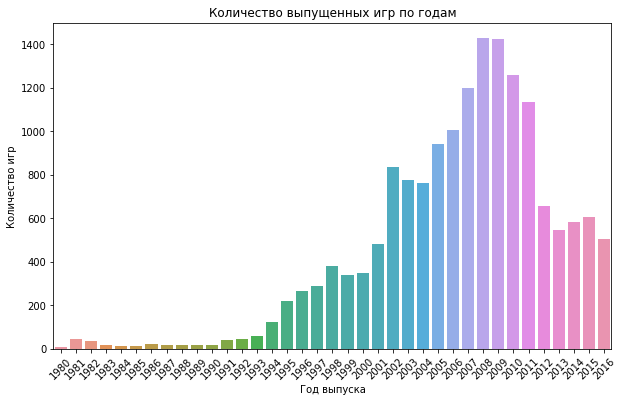

In [ ]:
games_years = df[df['year_of_release'] > 0].pivot_table(index = 'year_of_release',
        values = 'name', aggfunc = 'count').sort_values('year_of_release', ascending = False)
graph_bar(games_years, 'name', 'Год выпуска', 'Количество игр', 'Количество выпущенных игр по годам')

На графике видно резкие движения рынка выдеоигр. Начиная с 1994-1995 года, с выхода приставки PlayStation 1, начался заметный рост рынка.

Следующий пик проихошел в 2001-2002 годах: с выходом PlayStation 2 (самой продаваемой игровой приставкой в истории на данный момент), выходом на рынок приставок Microsoft c Xbox, а так же ростом и популярностью PC-платформ.

Пик продаж видеоигр пришелся на 2008-2009 годы. После этого начался спад, по все видимости, связанный с развитием мобильных устройств и социальных сетей, что привело к уменьшению рынка видеоигр.

Так как до 1994 года выпускалось меньше 100 игр в год, поэтому дальше будем рассматривать рынок начинаяс этого года

## 3.2 Количество выпущенных игр по платформам.

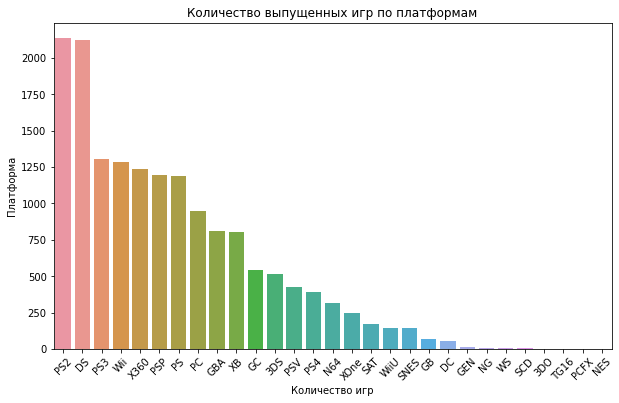

In [ ]:
platform_count = df[df['year_of_release'] >= 1994].pivot_table(index = 'platform',
      values = 'name', aggfunc = 'count').sort_values('name', ascending = False)
graph_bar(platform_count, 'name', 'Количество игр', 'Платформа', 'Количество выпущенных игр по платформам')

В очевидных лидерах платформы PlayStation 2 и Nintendo DS.

Со значительным отставанием следуют PlayStation 3, Wii, Xbox 360, PSP и PlayStation 1

## 3.3 Изменения продаж лидеров рынка платформ

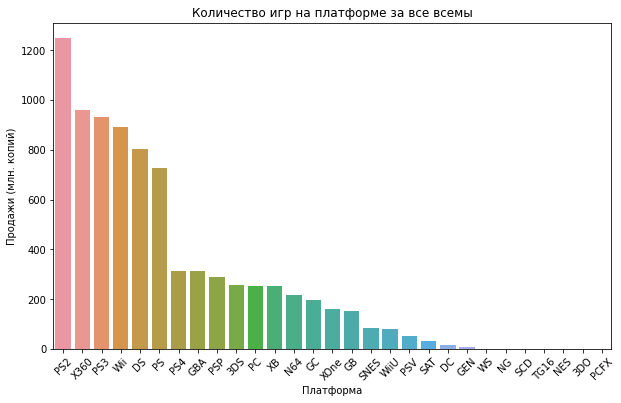

In [ ]:
platform_sales=df[df['year_of_release'] >= 1994].pivot_table(index = 'platform',
      values ='total_sales', aggfunc = 'sum').sort_values('total_sales', ascending=False)
graph_bar(platform_sales, 'total_sales', 'Платформа', 'Продажи (млн. копий)', 'Количество игр на платформе за все всемы')

По общей сумме продаж во всех регионах безусловным лидером является платформа PlayStation 2. В группе лидеров те же PlayStation 3, Wii, Xbox 360 и PlayStation 1

Пронаблюдаем за лидерами продаж на временном промежутке

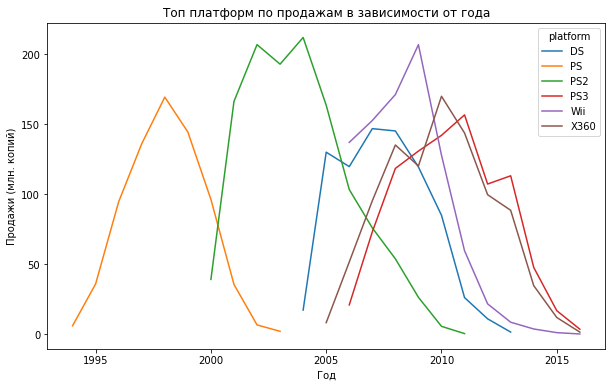

In [ ]:
# создадим список лидеров по продажам
platform_top = platform_sales.head(6).index.tolist()
# сводная таблица топ-платформ по продажам в зависимости от года
platform_top_sales = df[(df['platform'].isin(platform_top)) & (df['year_of_release'] >= 1994)].pivot_table(
    index = ['platform','year_of_release'], values = 'total_sales', aggfunc = 'sum').reset_index()
# график продаж в зависимости от года по каждой платформе
graph_line(platform_top_sales, 'year_of_release', 'total_sales', 'Год',
           'Продажи (млн. копий)', 'Топ платформ по продажам в зависимости от года')

По графику 6-ти топ-платформ видно, что средняя продолжительность нахождения платформы на рынке около 10 лет, после чего продажи игр на эти платформы сводится к минимальным.

## 3.4 Какие платформы лидируют по продажам, растут или падают?

Так как мы определили среднюю продолжительность нахождения пламформы на рынке в 10 лет, то (для 2017 года) отределим изучаемый период начиная с 2006 года.

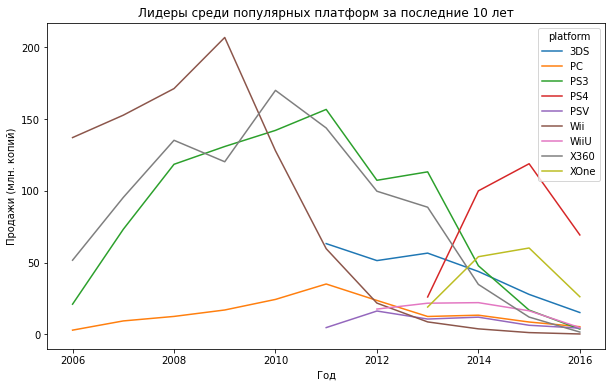

In [ ]:
# создадим список актуальных на 2016 год платформ
list_actual_platform = df[(df['year_of_release'] >= 2016)].pivot_table(index = ['platform'],
    values = 'total_sales', aggfunc = 'sum').sort_values('total_sales', ascending=False).head(10).index.tolist()
#
platform_trends = df[(df['platform'].isin(list_actual_platform)) & (df['year_of_release'] >= 2006)].pivot_table(
    index = ['platform','year_of_release'], values = 'total_sales', aggfunc = 'sum').reset_index()
# Построим график
graph_line(platform_trends, 'year_of_release', 'total_sales', 'Год',
           'Продажи (млн. копий)', 'Лидеры среди популярных платформ за последние 10 лет')

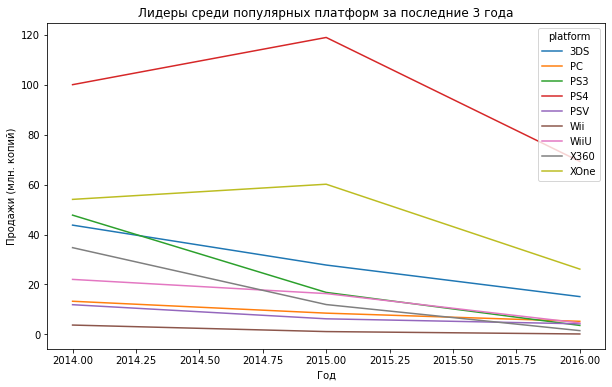

In [ ]:
platform_trends = df[(df['platform'].isin(list_actual_platform)) & (df['year_of_release'] >= 2014)].pivot_table(
    index = ['platform','year_of_release'], values = 'total_sales', aggfunc = 'sum').reset_index()
# Построим график
graph_line(platform_trends, 'year_of_release', 'total_sales', 'Год',
           'Продажи (млн. копий)', 'Лидеры среди популярных платформ за последние 3 года')

На конец 2006-го лидер продаж - PS4, затем платформа Xbox One. Но очевиден нисходящий тренд по продажам как для обоих лидеров, так и для остальных платформ

## 3.5 Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам.

Рассмотрим данные популярных платформ за 3 года, т.е. с 2014 го года включительно

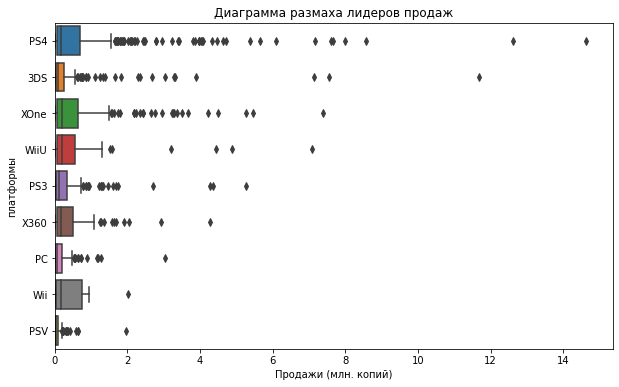

In [ ]:
actual_platform = df[(df['platform'].isin(list_actual_platform)) & (df['year_of_release'] >= 2014)]
#Полная диаграмма размаха
xlim = [0,None]
graph_box(actual_platform['total_sales'], actual_platform['platform'],
          'Продажи (млн. копий)', 'платформы', xlim, 'Диаграмма размаха лидеров продаж')

Практически у всех платформ были явные хиты которые на графике видны как большие выбросы. Чтобы лучше рассмотреть средние по продажам, ограничим выборку 2-мя миллионами проданных копий игр.

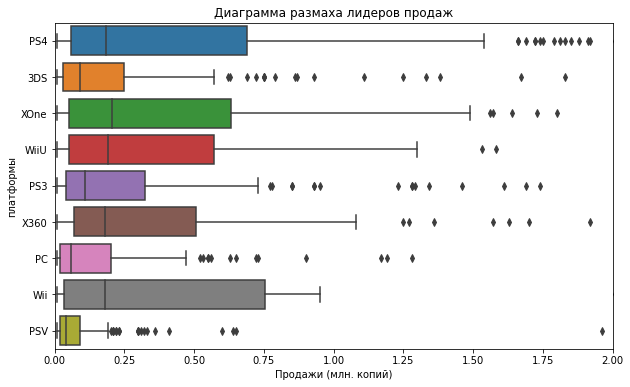

In [ ]:
xlim = [0,2]
graph_box(actual_platform['total_sales'], actual_platform['platform'], 'Продажи (млн. копий)',
          'платформы', xlim, 'Диаграмма размаха лидеров продаж')

У Xbox One среднее по продажам чуть большее чем у лидера - PlayStation 4, что может говорить о несколько большей общей стабильности продаж, в противовес стратегии лидера - явной ставки на хиты.

## 3.6 Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами.

Для построения диаграммы рассеяния возьмем лидера продаж последних 3-х лет - PlayStation 4
Для сравнения отобразим на графиках как оценки критиков - <span style="color:red">**красные**</span> точки, так и оценки пользователей <span style="color:blue">**голубые**</span> точки.

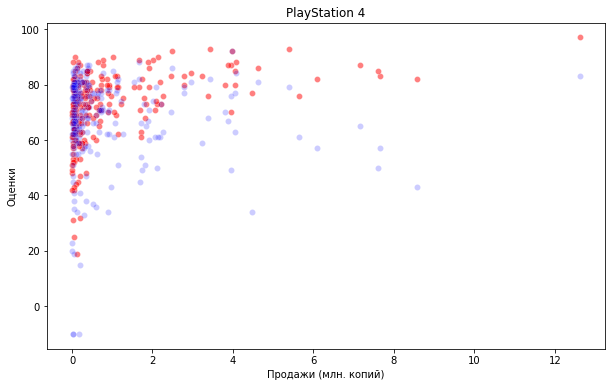

Корреляция продаж и оценки критиков для платформы "PlayStation 4": 0.403
Корреляция продаж и оценки пользователей для платформы "PlayStation 4": -0.005


In [ ]:
platform_ps4 = actual_platform[(actual_platform['platform'] == 'PS4') & (actual_platform['critic_score'] >= 0)]
graph_scatter(platform_ps4, 'PlayStation 4')

Очевидно прослеживается положительная корреляция оценок и продаж игр - чем выше оценки критиков, тем больше количество продаж.

Примечательно соотношение оценок критиков и оценок пользователей. На графиках видно как пользователи намного чаще ставят оценки играм несколько ниже чем профессиональные критики. Соответственно и корреляция оценок пользователей и продаж игр почти нулевая.

Проверия корреляцию для других платформ

## 3.7 Соотнесите выводы с продажами игр на других платформах.

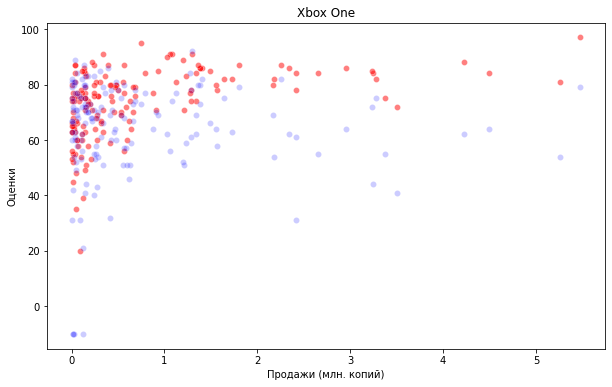

Корреляция продаж и оценки критиков для платформы "Xbox One": 0.429
Корреляция продаж и оценки пользователей для платформы "Xbox One": 0.007


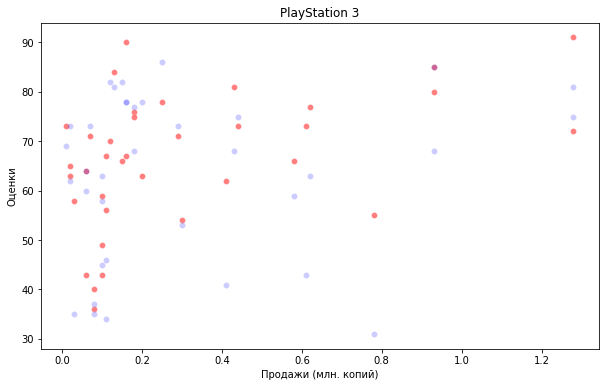

Корреляция продаж и оценки критиков для платформы "PlayStation 3": 0.447
Корреляция продаж и оценки пользователей для платформы "PlayStation 3": 0.157


In [ ]:
platform_xone = actual_platform[(actual_platform['platform'] == 'XOne') & (actual_platform['critic_score'] >= 0)]
graph_scatter(platform_xone, 'Xbox One')
platform_ps3 = actual_platform[(actual_platform['platform'] == 'PS3') & (actual_platform['critic_score'] >= 0)]
graph_scatter(platform_ps3, 'PlayStation 3')

Общая тенденция повторяется - положительная корреляция между оценками критиков и продажами. И заметно меньшая или отсутствующая корреляция между оценками пользователей и продажами.

## 3.8 Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах?

Найдем самые популярные жанры за все время продаж видеоигр

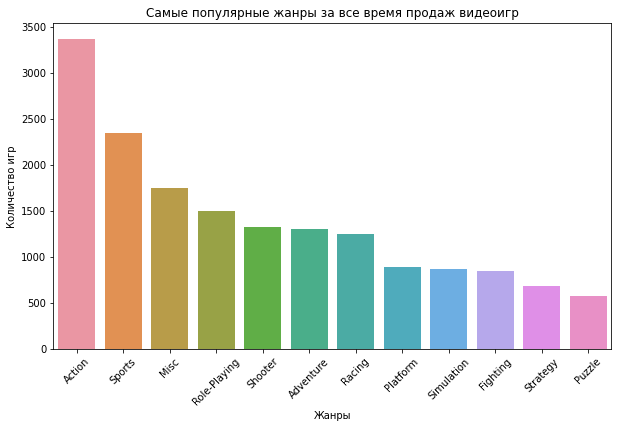

In [ ]:
game_genre_count = df.pivot_table(index = 'genre', values = 'name',
                                  aggfunc = 'count').sort_values('name', ascending = False)
graph_bar(game_genre_count, 'name', 'Жанры', 'Количество игр', 'Cамые популярные жанры за все время продаж видеоигр')

Популярные жанры за последние 3 года по количеству выпущеных игр

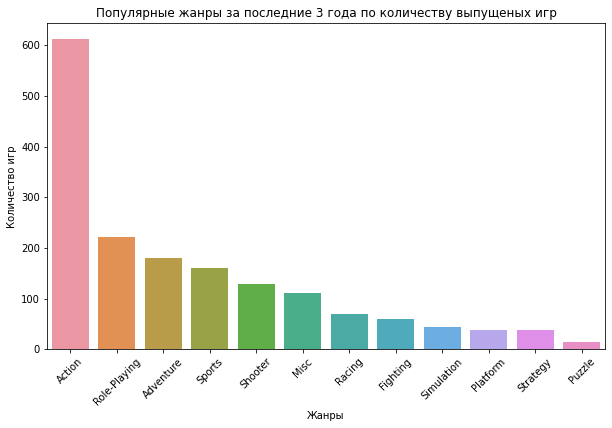

In [ ]:
actual_game_genre_count = actual_platform.pivot_table(index = 'genre', values = 'name',
                                                      aggfunc = 'count').sort_values('name', ascending = False)
graph_bar(actual_game_genre_count, 'name', 'Жанры', 'Количество игр', 'Популярные жанры за последние 3 года по количеству выпущеных игр')

По сравнению с показателями за все время наьлюдения, в последнее время сильно выросле количества игр в жанре Action и увеличелось количество ролевых игр (Role-Playing)

Посмотрим на популярность жанров относительно продаж

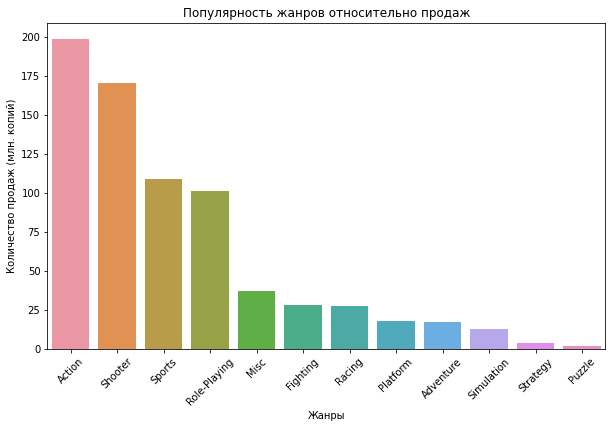

In [ ]:
actual_game_genre_sales = actual_platform.pivot_table(index = 'genre', values = 'total_sales',
                                                      aggfunc = 'sum').sort_values('total_sales', ascending = False)
graph_bar(actual_game_genre_sales, 'total_sales', 'Жанры', 'Количество продаж (млн. копий)', 'Популярность жанров относительно продаж')

По продажам в лидеры попадают жанры Shooter и Sports. Можно предположить что эти жанры более популярны у более взрослой аудитории, то есть у более платежеспособной. На первом месте тот же жанр Action но со значительно меньшим отрывом.

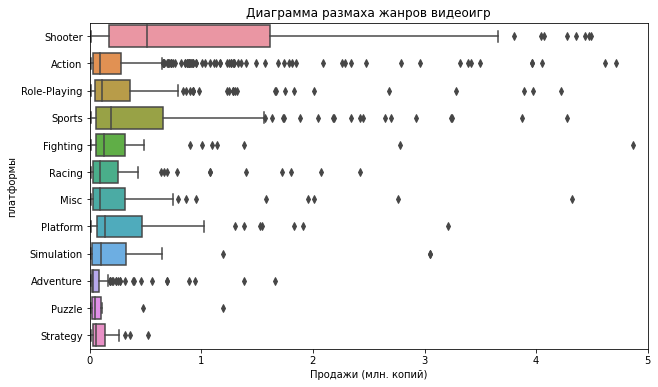

In [ ]:
xlim = [0,5]
graph_box(actual_platform['total_sales'], actual_platform['genre'], 'Продажи (млн. копий)',
          'платформы', xlim, 'Диаграмма размаха жанров видеоигр')

А вот диаграммы размаха дают другую картину: лидером становится жанр Shooter, со значительно более высоким показателем среднего по количеству продаж. Следом следует жанр Sports. А показатели Action здесь значительно скромнее. Можем сделать вывод, что игры в жанте Action лидитуют по количеству продаж из-за какого-то количества крайне популярных игр-хитов.

# 4. Портрет пользователя каждого региона: NA, EU, JP

Определим самые популярные платформы по регионам

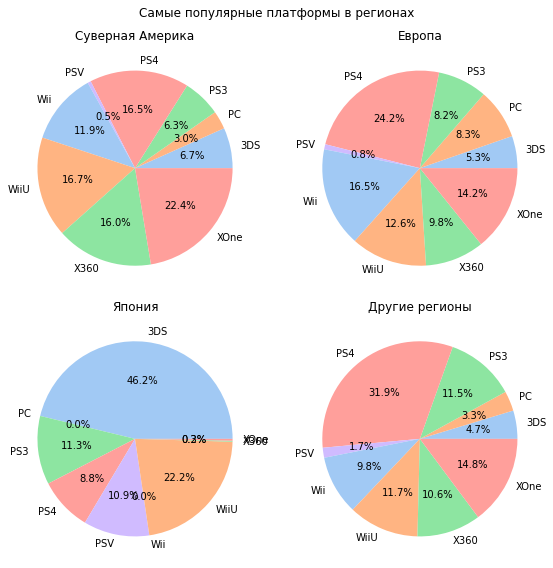

In [ ]:
platform_region_sales=actual_platform.pivot_table(index='platform',
                                                  values=['na_sales', 'eu_sales', 'jp_sales', 'other_sales'])
graph_pie(platform_region_sales, 'Самые популярные платформы в регионах')

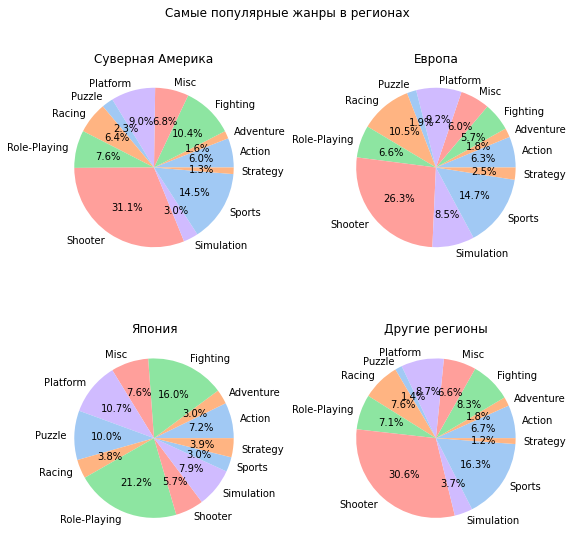

In [ ]:
genre_region_sales=actual_platform.pivot_table(index='genre',
                                               values=['na_sales', 'eu_sales', 'jp_sales', 'other_sales'])
graph_pie(genre_region_sales, 'Самые популярные жанры в регионах')

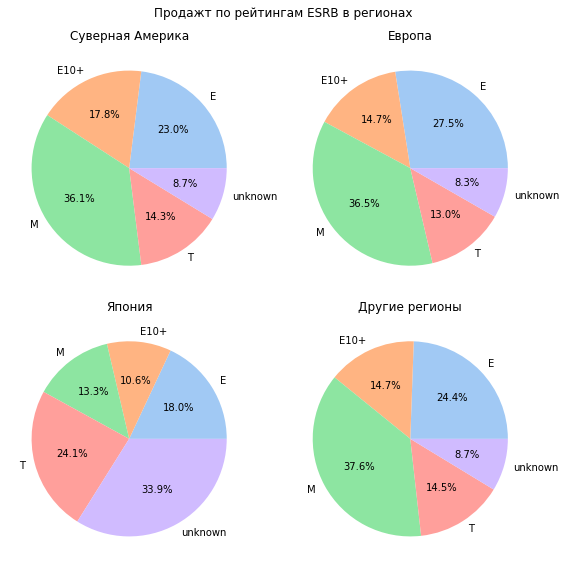

In [ ]:
rating_region_sales=actual_platform.pivot_table(index='rating',
                                                values=['na_sales', 'eu_sales', 'jp_sales', 'other_sales'])
graph_pie(rating_region_sales, 'Продажт по рейтингам ESRB в регионах')

По **диаграммам популярности платформ по регионам** можно заметить различия в предпочтениях Европы и Северной Америкой: в Европе чуть меньше четверти рынка занимает PS4, затем платформы Wii, Xbox One, WiiU. В Северной Америке наоборот, на первом месте Xbox One, затем платформы Wii, PS4 X360.

Кардинальные различия у японских пользователей. Здесь почти с половину ранка занимает портативная система Nintendo 3DS. Далее по популярности WiiU и семейство PlayStation. Платфориы Xbox от Microsoft а так же игры на PC практически не пользуются спросом.

Предпочтения в платформах в других регионах больше походят на предпочтения Европы с еще несколько большей популярностьб PS4.

**Диаграммам продаж по жанрам** во всех регионах кроме Японии похожи. Лидируют шутеры затем игры в категории Sport.

В японском регионе портрет пользователя совсем другой. Первое место по предпочтениям Role-Playing и Fighting.

По **рейтингам ESRB** во всех регионах (опять же кроме Японии) больше трети продаж происходят в категории M («Для взрослых»: Материалы игры не подходящие для лиц младше 17 лет) В Японском регионе эта доля снижена до 13%. Далее по распространению "детские" - категории E и E10+

# 5. Проверка гипотез

## 5.1 Гипотеза: средние пользовательские рейтинги платформ Xbox One и PC одинаковые

*   Нулевая гипотеза (H0): средние пользовательские рейтинги платформ Xbox One и PC одинаковые
*   Альтернативная гипотеза (H1): средние пользовательские рейтинги платформ Xbox One и PC разные

Для выбора метода проверки гипотезы создадим две выборки

In [ ]:
user_score_pc = df[(df['platform'] == 'PC') & (df['user_score'] >= 0)]['user_score']
user_score_xone = df[(df['platform'] == 'XOne') & (df['user_score'] >= 0)]['user_score']

print('Количество значений выборки для платформы PC:', user_score_pc.shape[0])
print('Количество значений выборки для платформы Xbox One:', user_score_xone.shape[0])

Количество значений выборки для платформы PC: 770
Количество значений выборки для платформы Xbox One: 182


Для проверки гипотезы применим t-тест

Так как выборки получились разного размера, есть вероятность что дисперсии у совокупностей разные, то зададим параметр equal_var = False

In [ ]:
alpha = 0.05

result = st.ttest_ind(user_score_pc, user_score_xone, equal_var = False)

print('Значение P-value ', round(result.pvalue, 5))

if result.pvalue < alpha:
    print('Отвергаем гипотезу H0, в пользу гипотезы H1')
else:
    print('Не можем отвергнуть гипотезу H0')

Значение P-value  0.0
Отвергаем гипотезу H0, в пользу гипотезы H1


In [ ]:
# проверка
print('Среднее значение оценок пользователей платформы PC:', round(user_score_pc.mean(),2))
print('Среднее значение оценок пользователей платформы Xbox One:', round(user_score_xone.mean(),2))

Среднее значение оценок пользователей платформы PC: 70.62
Среднее значение оценок пользователей платформы Xbox One: 65.21


В результате проверки гипотезы с использованием t-теста, мы пришли к выводу, что мы не можем отвергнуть гипотезу о том, что средние оценки пользователей генеральных совокупностей для платформ PC и Xbox One одинаковы, так как вероятность этого меньше уровня значимости.

## 5.2 Средние пользовательские рейтинги жанров Action и Sports разные.

*   Нулевая гипотеза (H0): средние пользовательские рейтинги жанров Action и Sports равны
*   Альтернативная гипотеза (H1): средние пользовательские рейтинги жанров Action и Sports разные

In [ ]:
user_score_аction = df[df['genre'] == 'Action']['user_score']
user_score_sports = df[df['genre'] == 'Sports']['user_score']

print('Количество значений выборки для жанра Action:', user_score_аction.shape[0])
print('Количество значений выборки для жанра Sports:', user_score_sports.shape[0])

Количество значений выборки для жанра Action: 3369
Количество значений выборки для жанра Sports: 2348


Аналогично, для проверки гипотезы применим t-тест

Так как и здесь выборки получились разного размера, есть вероятность что дисперсии у совокупностей разные, то зададим параметр equal_var = False

In [ ]:
alpha = 0.05

result = st.ttest_ind(user_score_аction, user_score_sports, equal_var = False)

print('Значение P-value ', round(result.pvalue, 5))

if result.pvalue < alpha:
    print('Отвергаем гипотезу H0, в пользу гипотезы H1')
else:
    print('Не можем отвергнуть гипотезу H0')

Значение P-value  0.0
Отвергаем гипотезу H0, в пользу гипотезы H1


In [ ]:
# проверка
print('Среднее значение оценок пользователей жанра Action:', round(user_score_аction.mean(),2))
print('Среднее значение оценок пользователей жанра Sports:', round(user_score_sports.mean(),2))

Среднее значение оценок пользователей жанра Action: 33.75
Среднее значение оценок пользователей жанра Sports: 27.4


Мы отвергаем гипотезу о том, что средние пользовательских оценок для жанров Action и Sports одинаковы, потому что вероятность этого меньше уровня значимости. Соответственно, подтверждаем альтернативную теорию - средние пользовательских оценок для жанров Action и Sports в генеральной совокупности разные.

# 6. Общий вывод

На данных датасета из /datasets/games.csv была проведена предобработка данных:
*   скорректированы названия всех колонок
*   обработаны пропуски и дубли
*   произведено изменение типа данных
*   посчитаны суммарные продажи во всех регионах


Проведен исследовательский анализ данных

*   В результате анализа выявили общий пик продаж на рынке видеоигр в 2008-2009 годах, и дальнейшее, вплоть до настоящего момента, снижение продаж.

*   Обнаружили, что среднее время популярности платформы около 10-ти лет.

*   Самыми перспективными на 2017 год можно считать платформы PlayStation 4 и Xbox One. В то же время обе платформы прошли пик популярности и можно прогнозировать появление и рост популярности новых версий этих платформ или появление новых.

*   Выяснилось, что оценки критиков очевидно способствуют продажам игр, в то время как оценки пользователей практически не имеют почти никакой корреляции с продажами.


Анализ портрета пользователя на регионам

*   В Северной Америке по продажам лидирует платформа Xbox One. Затем PlayStation 4, WiiU, Xbox 360 равными долями. Среди предпочитаемых жанров -  Shooter и Sports.
*   В Европейском регионе предпочитают игры на платформе PlayStation 4. И популярны те же жанры Shooter и Sports.
*   Японский рынок сильно отличается от предыдущих. Почти половину рынка занимает платформа Nintendo 3DS. Популярны жанры Role-Playining и Fighting
*   Остальные регионы по предпочтениям платформ и игр близки к предпочтениям Европы


Проверили гипотезы

*   В результате проверки отвергли гипотезу о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые
*   Так же отвергли гипотезу о том, что средние пользовательских оценок для жанров Action и Sports одинаковы в пользу гипотезы, что они разные.